# Exploratory Data Analysis (EDA) of Gene Expression Data

### Project Introduction
The objective of this notebook is to perform a comprehensive exploratory data analysis on the TCGA-BRCA RNA-sequencing dataset. The focus here is on understanding the fundamental properties of the data itself. This process helps build intuition about the structure of gene expression data.

--- 
### References

**Data Sources and Platforms**
* [The Cancer Genome Atlas (TCGA)](https://www.cancer.gov/tcga): The primary data used in this analysis originates from the TCGA program, a landmark cancer genomics program that molecularly characterized over 20,000 primary cancer and matched normal samples spanning 33 cancer types

* [UCSC Xena Browser](https://xenabrowser.net/datapages/): The specific clinical and gene expression data files were accessed via the UCSC Xena platform, which provides an intuitive interface for exploring and downloading processed TCGA and other large genomic datasets.

**Survival Libraries**
* [Scikit Survival Docs](https://scikit-survival.readthedocs.io/en/stable/index.html)
* [Lifeline Docs](https://lifelines.readthedocs.io/en/latest/index.html)

---
### Table of Contents

1. [Imports](#imports)
2. [Constants & Data](#constants)
3. ...
8. [Summary](#summary)

---
### 1. Imports <a class="anchor" id="imports"></a>

In [1]:
import os
from pathlib import Path
from typing import Tuple 

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.nonparametric import kaplan_meier_estimator

from statsmodels.stats.outliers_influence import variance_inflation_factor
import umap

/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
### 2. Constants & Data Import <a class="anchor" id="constants"></a>


The necessary data files can be accessed and downloaded via the GDC TCGA Breast Cancer (BRCA) portal on the [UCSC Xena Functional Genomics Browser](https://xenabrowser.net/datapages/?cohort=GDC%20TCGA%20Breast%20Cancer%20(BRCA)&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443). The following specific datasets are required:

* **Gene Expression (RNA-Seq)**: 

    *gene expression RNAseq --> STAR - FPKM-UQ*

    The STAR - FPKM-UQ file provides gene expression levels for 58,049 genes. This dataset is derived from RNA sequencing (RNA-Seq) data that has been aligned to the human genome using the STAR (Splicer-Aware Transcriptome Alignment for RNA) aligner.

* **Phenotype and Survival Data**: 

    *phenotype --> survival data*

    The phenotype file contains detailed clinical information for each patient in the TCGA-BRCA cohort.
    
* **Gene Mapping**

    *GDC.h38 GENCODE TSV (v22)*

    The gencode.gene.info.v22.tsv file contains the mapping between Ensembl IDs and the gene symbols. File can be downloaded [here](https://gdc.cancer.gov/about-data/gdc-data-processing/gdc-reference-files)


The notebook expects both tsv files to be placed in the `data/` folder.

In [2]:
ROOT = Path(os.getcwd()).parents[0]

DATA_PATH = os.path.join(ROOT, "data", "TCGA-BRCA.star_fpkm-uq.tsv")
CLINICAL_DATA_PATH = os.path.join(ROOT, "data", "TCGA-BRCA.clinical.tsv")
MAPPING_FILE_PATH = os.path.join(ROOT, "data", "gencode.gene.info.v22.tsv")

In [3]:
df = pd.read_csv(DATA_PATH, sep="\t", index_col=0).drop_duplicates()
df_mapping = pd.read_csv(MAPPING_FILE_PATH, sep="\t", index_col=0).drop_duplicates()
df_clinical = pd.read_csv(CLINICAL_DATA_PATH, sep="\t", index_col=0).drop_duplicates()

display(df.head())
print(f"Number of genes: {df.shape[0]}")
print(f"Number of samples: {df.shape[1]}")
display(df_clinical.head())
print(f"Number of clinical samples: {df_clinical.shape[0]}")
print(f"Number of clinical features: {df_clinical.shape[1]}")
display(df_mapping.head())

,TCGA-D8-A146-01A,TCGA-AQ-A0Y5-01A,TCGA-C8-A274-01A,TCGA-BH-A0BD-01A,TCGA-B6-A1KC-01B,TCGA-AC-A62V-01A,TCGA-AO-A0J5-01A,TCGA-BH-A0B1-01A,TCGA-A2-A0YM-01A,TCGA-AO-A03N-01B,...,TCGA-E2-A1IG-01A,TCGA-E9-A1NA-01A,TCGA-D8-A1JP-01A,TCGA-AR-A252-01A,TCGA-D8-A1XL-01A,TCGA-BH-A0EI-01A,TCGA-E2-A1IO-01A,TCGA-E2-A15R-01A,TCGA-B6-A0IP-01A,TCGA-A1-A0SN-01A
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.15,3.767708,2.132741,4.768010,3.049735,3.009311,2.262163,2.929999,4.243105,4.231540,3.126461,...,3.083077,2.463256,3.263365,3.203264,3.653874,4.470745,4.214863,1.175109,5.008083,1.993783
ENSG00000000005.6,1.759454,0.146003,0.000000,1.071763,0.185993,0.308594,0.467071,0.121281,0.124196,0.000000,...,0.038015,0.045024,0.023184,1.922426,0.000000,0.104739,0.224658,0.127501,0.165172,0.015783
ENSG00000000419.13,4.920541,5.284151,5.051694,4.618797,4.852973,5.364065,3.958935,5.171995,4.771500,5.550193,...,4.556411,4.596321,5.213518,4.374831,5.696970,5.234413,4.876325,4.975405,4.569892,6.213147
ENSG00000000457.14,2.612588,2.428544,3.356299,2.680774,2.381671,1.128095,2.787265,2.398214,1.637378,1.876527,...,2.257493,2.141498,3.250295,2.203232,2.196827,2.030407,2.303109,2.895225,2.681697,2.431356
ENSG00000000460.17,1.363395,1.158337,2.458172,2.494236,1.565841,1.249809,1.221939,1.857344,2.197771,1.396050,...,1.223670,1.222805,2.184534,1.291250,1.736778,1.531219,1.123070,1.955015,1.791314,1.716025


Number of genes: 58049
Number of samples: 1226


,id,disease_type,case_id,submitter_id,primary_site,alcohol_history.exposures,race.demographic,gender.demographic,ethnicity.demographic,vital_status.demographic,...,days_to_collection.samples,initial_weight.samples,preservation_method.samples,pathology_report_uuid.samples,oct_embedded.samples,specimen_type.samples,days_to_sample_procurement.samples,is_ffpe.samples,tissue_type.samples,annotations.samples
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-BH-A0W3-01A,3c612e12-6de8-44fa-a095-805c45474821,Ductal and Lobular Neoplasms,3c612e12-6de8-44fa-a095-805c45474821,TCGA-BH-A0W3,Breast,Not Reported,white,female,not hispanic or latino,Alive,...,85.0,120.0,OCT,801A4E2F-E26E-424F-BF42-CD0D9CD62BCE,True,Solid Tissue,NaN,False,Tumor,NaN
TCGA-AR-A24V-01A,3cb06c7a-f2a8-448b-91a8-dd201bbf2ddd,Ductal and Lobular Neoplasms,3cb06c7a-f2a8-448b-91a8-dd201bbf2ddd,TCGA-AR-A24V,Breast,Not Reported,white,female,not hispanic or latino,Alive,...,1720.0,400.0,OCT,468CD293-C9F7-43C6-A40A-18FCDD22F6AA,True,Solid Tissue,NaN,False,Tumor,NaN
TCGA-E9-A1NE-01A,3d676bba-154b-4d22-ab59-d4d4da051b94,Ductal and Lobular Neoplasms,3d676bba-154b-4d22-ab59-d4d4da051b94,TCGA-E9-A1NE,Breast,Not Reported,white,female,not hispanic or latino,Alive,...,31.0,280.0,OCT,CF6E29A2-FAE6-45BB-B625-33877887A89E,True,Solid Tissue,NaN,False,Tumor,NaN
TCGA-E9-A1NE-11A,3d676bba-154b-4d22-ab59-d4d4da051b94,Ductal and Lobular Neoplasms,3d676bba-154b-4d22-ab59-d4d4da051b94,TCGA-E9-A1NE,Breast,Not Reported,white,female,not hispanic or latino,Alive,...,31.0,830.0,OCT,NaN,True,Solid Tissue,NaN,False,Normal,NaN
TCGA-AC-A8OQ-01A,dfaabd03-2d40-4422-b210-caf112ff4229,Ductal and Lobular Neoplasms,dfaabd03-2d40-4422-b210-caf112ff4229,TCGA-AC-A8OQ,Breast,Not Reported,black or african american,female,not hispanic or latino,Alive,...,742.0,100.0,Unknown,FFA6F9F3-71C1-4AF9-B9F7-0466550EBC90,False,Solid Tissue,NaN,False,Tumor,NaN


Number of clinical samples: 1255
Number of clinical features: 84


,gene_name,seqname,start,end,strand,gene_type,gene_status,havana_gene,full_length,exon_length,exon_num
gene_id,,,,,,,,,,,
ENSG00000223972.5,DDX11L1,chr1,11869,14409,+,transcribed_unprocessed_pseudogene,KNOWN,OTTHUMG00000000961.2,2541,1735,9
ENSG00000238009.5,RP11-34P13.7,chr1,89295,133723,-,lincRNA,NOVEL,OTTHUMG00000001096.2,44429,3726,17
ENSG00000230415.1,RP5-902P8.10,chr1,1275223,1280420,+,lincRNA,NOVEL,OTTHUMG00000002234.2,5198,513,5
ENSG00000236335.1,RP4-591L5.1,chr1,30409560,30411638,-,lincRNA,NOVEL,OTTHUMG00000003682.1,2079,507,3
ENSG00000213842.2,SUGT1P2,chr3,32752910,32753901,+,processed_pseudogene,KNOWN,OTTHUMG00000155904.1,992,992,1


Add a `duration` column consistent with the survival analysis performed in the `brca_gene_expression_survival.ipynb` notebook.

In [41]:
df_clinical["event"] = (
    (df_clinical['vital_status.demographic'] == 'Dead').astype(int)
)
df_clinical["duration"] = df_clinical.apply(
    lambda x: x["days_to_death.demographic"]
    if x["event"]
    else x["days_to_last_follow_up.diagnoses"],
    axis=1,
)

---
### 3. What does the distribution of gene expression look like? <a class="anchor" id="distributions"></a>

...

#### Visualize Mean Expression

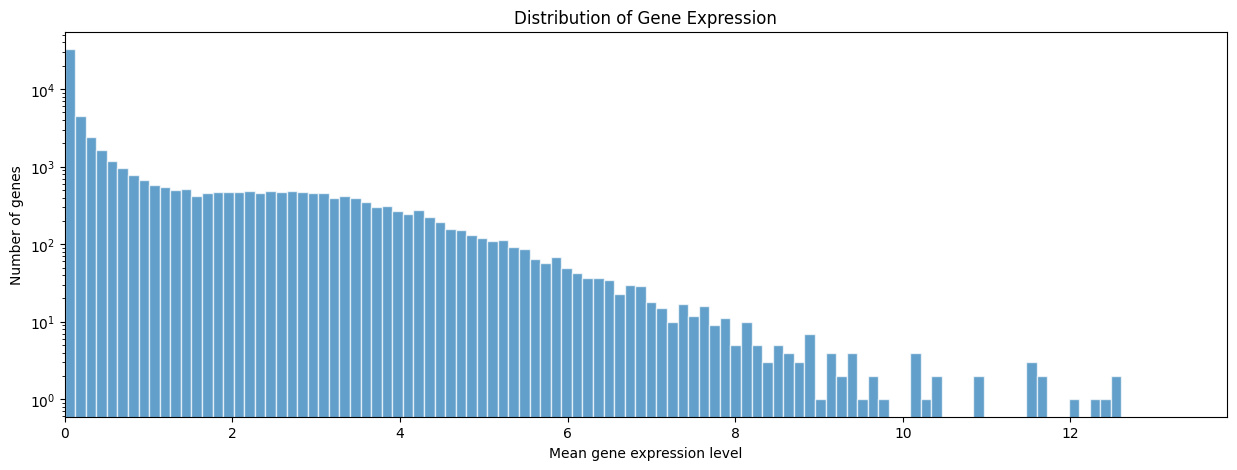

In [4]:
_, axes = plt.subplots(figsize=(15, 5))
df.mean(axis=1).hist(
    bins=100,
    ax=axes,
    edgecolor='white',
    alpha=0.7,
    grid=False
)
plt.title("Distribution of Gene Expression")

plt.xlabel("Mean gene expression level")
plt.ylabel("Number of genes")
axes.set_yscale('log')
plt.xlim(0, df.mean(axis=1).max() * 1.1);

#### Visualize Expression Variance

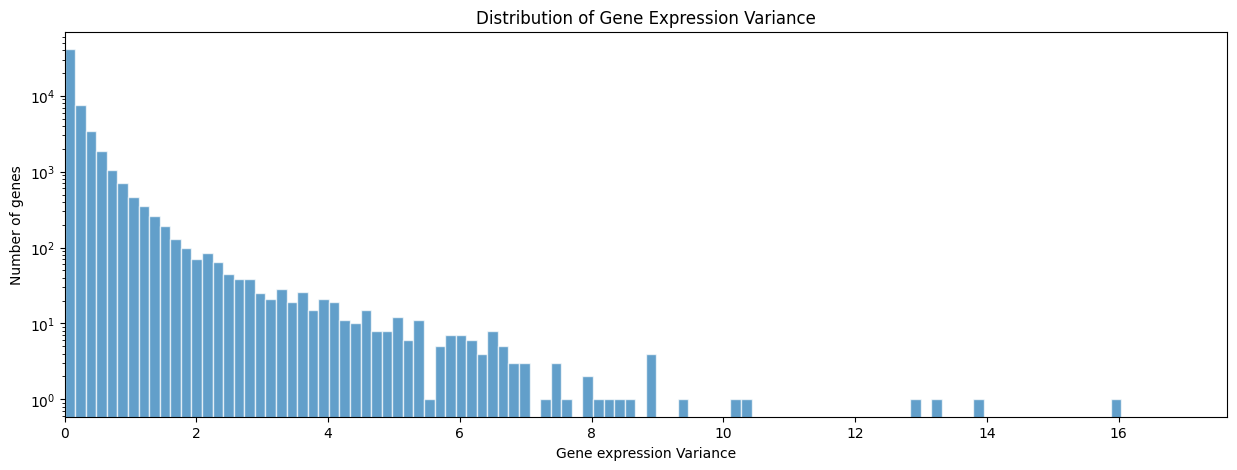

In [5]:
_, axes = plt.subplots(figsize=(15, 5))
df.var(axis=1).hist(
    bins=100,
    ax=axes,
    edgecolor='white',
    alpha=0.7,
    grid=False
)
plt.title("Distribution of Gene Expression Variance")

plt.xlabel("Gene expression Variance")
plt.ylabel("Number of genes")
axes.set_yscale('log')
plt.xlim(0, df.var(axis=1).max() * 1.1);

#### What are the genes with the highest mean expression?
Every cell needs a basic set of genes that are constitutively expressed in cells and are essential for basic cellular functions. These genes encode for proteins that are involved in fundamental cellular processes, such as cell cycle regulation, DNA replication, and metabolism.[1] Which genes represent those so-called "housekeeping" genes here?

[1]https://www.genomics-online.com/resources/16/5049/housekeeping-genes/#:~:text=Housekeeping%20genes%2C%20also%20known%20as,%2C%20DNA%20replication%2C%20and%20metabolism.

In [6]:
df_highest_expression = df.mean(axis=1).sort_values(ascending=False).to_frame()
df_highest_expression = df_highest_expression.reset_index()
df_highest_expression.columns = ['Ensembl_ID', 'mean_expression']
df_highest_expression['gene_symbols'] = df_highest_expression['Ensembl_ID'].map(df_mapping['gene_name'])
df_highest_expression.head(10)

,Ensembl_ID,mean_expression,gene_symbols
0,ENSG00000198938.2,12.608721,MT-CO3
1,ENSG00000198712.1,12.485528,MT-CO2
2,ENSG00000198804.2,12.447667,MT-CO1
3,ENSG00000198886.2,12.325999,MT-ND4
4,ENSG00000210082.2,12.007652,MT-RNR2
5,ENSG00000198899.2,11.690718,MT-ATP6
6,ENSG00000198727.2,11.658371,MT-CYB
7,ENSG00000198888.2,11.569408,MT-ND1
8,ENSG00000198840.2,11.559240,MT-ND3
9,ENSG00000198763.3,11.517366,MT-ND2


The genes with the highest mean expression tend to be mitochondrial genes.  These are indeed expected to be the housekeeping genes as they are responsible for producing energy (ATP) for the cell.

#### What are the genes with the lowest mean expression?

In [7]:
df_lowest_expression = df_highest_expression.sort_values(by='mean_expression', ascending=True).dropna()
df_lowest_expression.head(10)

,Ensembl_ID,mean_expression,gene_symbols
58046,ENSG00000172288.7,0.000006,CDY1
58042,ENSG00000137808.12,0.000007,RP11-809H16.2
58041,ENSG00000254445.1,0.000007,HSPB2-C11orf52
58038,ENSG00000227140.3,0.000009,USP17L5
58036,ENSG00000236379.2,0.000009,ZNF736P4Y
58035,ENSG00000276998.1,0.000010,REXO1L2P
58030,ENSG00000277422.1,0.000013,REXO1L6P
58029,ENSG00000225466.1,0.000013,OFD1P10Y
58028,ENSG00000231159.1,0.000013,OFD1P8Y
58027,ENSG00000234749.5,0.000013,FAM90A21P


The Y at the end of CDY, ZNF736P4Y, OFD1P10Y and OFD1P8Y indicate that these genes are located on the Y chromosome. Given that all individuals in this cohort are female, it makes sense that these are silent.

#### Which genes are the most variable?
Genes with a high variance indicate the most dynamic activity across the patient population.  These genes are the most likely candidates to be involved in driving the disease and are therefore the best features for a predictive model.

In [8]:
df_highest_variance = df.var(axis=1).sort_values(ascending=False).to_frame()
df_highest_variance = df_highest_variance.reset_index()
df_highest_variance.columns = ['Ensembl_ID', 'expression_variance']
df_highest_variance['gene_symbols'] = df_highest_variance['Ensembl_ID'].map(df_mapping['gene_name'])
df_highest_variance.head(10)

,Ensembl_ID,expression_variance,gene_symbols
0,ENSG00000110484.7,16.042655,NaN
1,ENSG00000124935.4,13.953442,NaN
2,ENSG00000159763.4,13.281801,NaN
3,ENSG00000160182.3,12.962014,NaN
4,ENSG00000153002.12,10.305483,NaN
5,ENSG00000244468.1,10.123320,RP11-206M11.7
6,ENSG00000012223.13,9.411067,NaN
7,ENSG00000143556.9,8.955834,NaN
8,ENSG00000172551.11,8.931992,NaN
9,ENSG00000166509.12,8.914714,NaN


Interestingly, the majority of the most dynamic genes are not characterized with a gene_symbol in this mapping.

In [9]:
df_highest_variance.dropna().head(10)

,Ensembl_ID,expression_variance,gene_symbols
5,ENSG00000244468.1,10.123320,RP11-206M11.7
12,ENSG00000160180.15,8.444090,TFF3
25,ENSG00000211673.2,6.868439,IGLV3-1
30,ENSG00000234918.1,6.616568,RP11-20F24.2
31,ENSG00000211945.2,6.610487,IGHV1-18
34,ENSG00000211598.2,6.553837,IGKV4-1
37,ENSG00000239951.1,6.520585,IGKV3-20
39,ENSG00000211666.2,6.490051,IGLV2-14
40,ENSG00000211679.2,6.441903,IGLC3
41,ENSG00000243466.1,6.349453,IGKV1-5


Seven of the top ten genes by variance are those that code for antibodies (i.e., prefixed by IG..).  This could make sense if the expression of these genes is a proxy for the number of B-cells present in the tissue as B-cells are responsible for creating antibodies.  This high variance indicates that the immune response to the cancer may be important during modeling.

**Observations**: 
* The genetic expression of this cohort demonstrates a long tail distribution with a low percentage of genes displaying relatively high expression. 
* There is a very large peak near zero, representing the tens of thousands of genes that have very low or no expression in breast tissue.
* The "housekeeping" genes with the highest mean expression tend to be mitochondrial genes.
* On the other hand, the "silent" genes in this dataset include those that are found on the Y chromosome
* Those genes that have the most dynamic activity (highest variance) tend to be immunoglobulin genes.

---
### 4. Analyze the Data Signal <a class="anchor" id="distributions"></a>

In [42]:
#Take the genes with the top 1% highest variance
most_active_genes = df_highest_expression.iloc[:int(len(df_highest_expression) * 0.01)]['Ensembl_ID'].tolist()

umap_model = umap.UMAP(n_components=2, n_neighbors=15, random_state=42)
reduced_data = umap_model.fit_transform(df.loc[most_active_genes].T)  
reduced_df = pd.DataFrame(reduced_data, columns=['UMAP1', 'UMAP2'], index=df.columns)

reduced_df = reduced_df.merge(df_clinical, left_index=True, right_index=True)
reduced_df.head()

/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,UMAP1,UMAP2,id,disease_type,case_id,submitter_id,primary_site,alcohol_history.exposures,race.demographic,gender.demographic,...,preservation_method.samples,pathology_report_uuid.samples,oct_embedded.samples,specimen_type.samples,days_to_sample_procurement.samples,is_ffpe.samples,tissue_type.samples,annotations.samples,event,duration
TCGA-D8-A146-01A,-4.454126,2.762461,03da7a65-fa2f-42cb-a709-5fe8736f21d3,Ductal and Lobular Neoplasms,03da7a65-fa2f-42cb-a709-5fe8736f21d3,TCGA-D8-A146,Breast,Not Reported,white,female,...,Unknown,79749F5D-329A-400D-8511-C4CF479C1FCC,False,Solid Tissue,NaN,False,Tumor,NaN,0,643.0
TCGA-AQ-A0Y5-01A,-3.805499,1.653198,d0b78f3f-a198-437a-ab8c-204345d3b75d,Ductal and Lobular Neoplasms,d0b78f3f-a198-437a-ab8c-204345d3b75d,TCGA-AQ-A0Y5,Breast,Not Reported,white,female,...,Unknown,5BC01981-366E-44EC-A986-087DB7904E5C,False,Solid Tissue,NaN,False,Tumor,NaN,1,172.0
TCGA-C8-A274-01A,-3.969343,0.405015,dbcad60f-86c7-41e3-b0ae-baa39c9f83dd,Ductal and Lobular Neoplasms,dbcad60f-86c7-41e3-b0ae-baa39c9f83dd,TCGA-C8-A274,Breast,Not Reported,asian,female,...,OCT,A7FAA4F2-1846-48CF-9FB5-15E98430F6CE,True,Solid Tissue,NaN,False,Tumor,NaN,0,508.0
TCGA-BH-A0BD-01A,-3.920324,3.222028,b379bfb8-284e-4300-8325-85cfd6809cb8,Ductal and Lobular Neoplasms,b379bfb8-284e-4300-8325-85cfd6809cb8,TCGA-BH-A0BD,Breast,Not Reported,white,female,...,OCT,CE70DD1E-BCA4-4F89-AA5B-D90FE18A36FF,True,Solid Tissue,NaN,False,Tumor,NaN,0,554.0
TCGA-B6-A1KC-01B,-4.999394,0.122100,1502c7d7-1535-4e56-9f34-30623acd50d5,Ductal and Lobular Neoplasms,1502c7d7-1535-4e56-9f34-30623acd50d5,TCGA-B6-A1KC,Breast,Not Reported,white,female,...,OCT,E1FDF8EB-9D75-4629-9C78-6019DAF8190E,True,Solid Tissue,NaN,False,Tumor,NaN,0,1326.0


In [43]:
reduced_df.columns

Index(['UMAP1', 'UMAP2', 'id', 'disease_type', 'case_id', 'submitter_id',
       'primary_site', 'alcohol_history.exposures', 'race.demographic',
       'gender.demographic', 'ethnicity.demographic',
       'vital_status.demographic', 'age_at_index.demographic',
       'days_to_birth.demographic', 'year_of_birth.demographic',
       'year_of_death.demographic', 'primary_site.project',
       'project_id.project', 'disease_type.project', 'name.project',
       'name.program.project', 'tissue_source_site_id.tissue_source_site',
       'code.tissue_source_site', 'name.tissue_source_site',
       'project.tissue_source_site', 'bcr_id.tissue_source_site',
       'days_to_death.demographic', 'entity_submitter_id.annotations',
       'notes.annotations', 'submitter_id.annotations',
       'classification.annotations', 'entity_id.annotations',
       'created_datetime.annotations', 'annotation_id.annotations',
       'entity_type.annotations', 'updated_datetime.annotations',
       'case_id.an

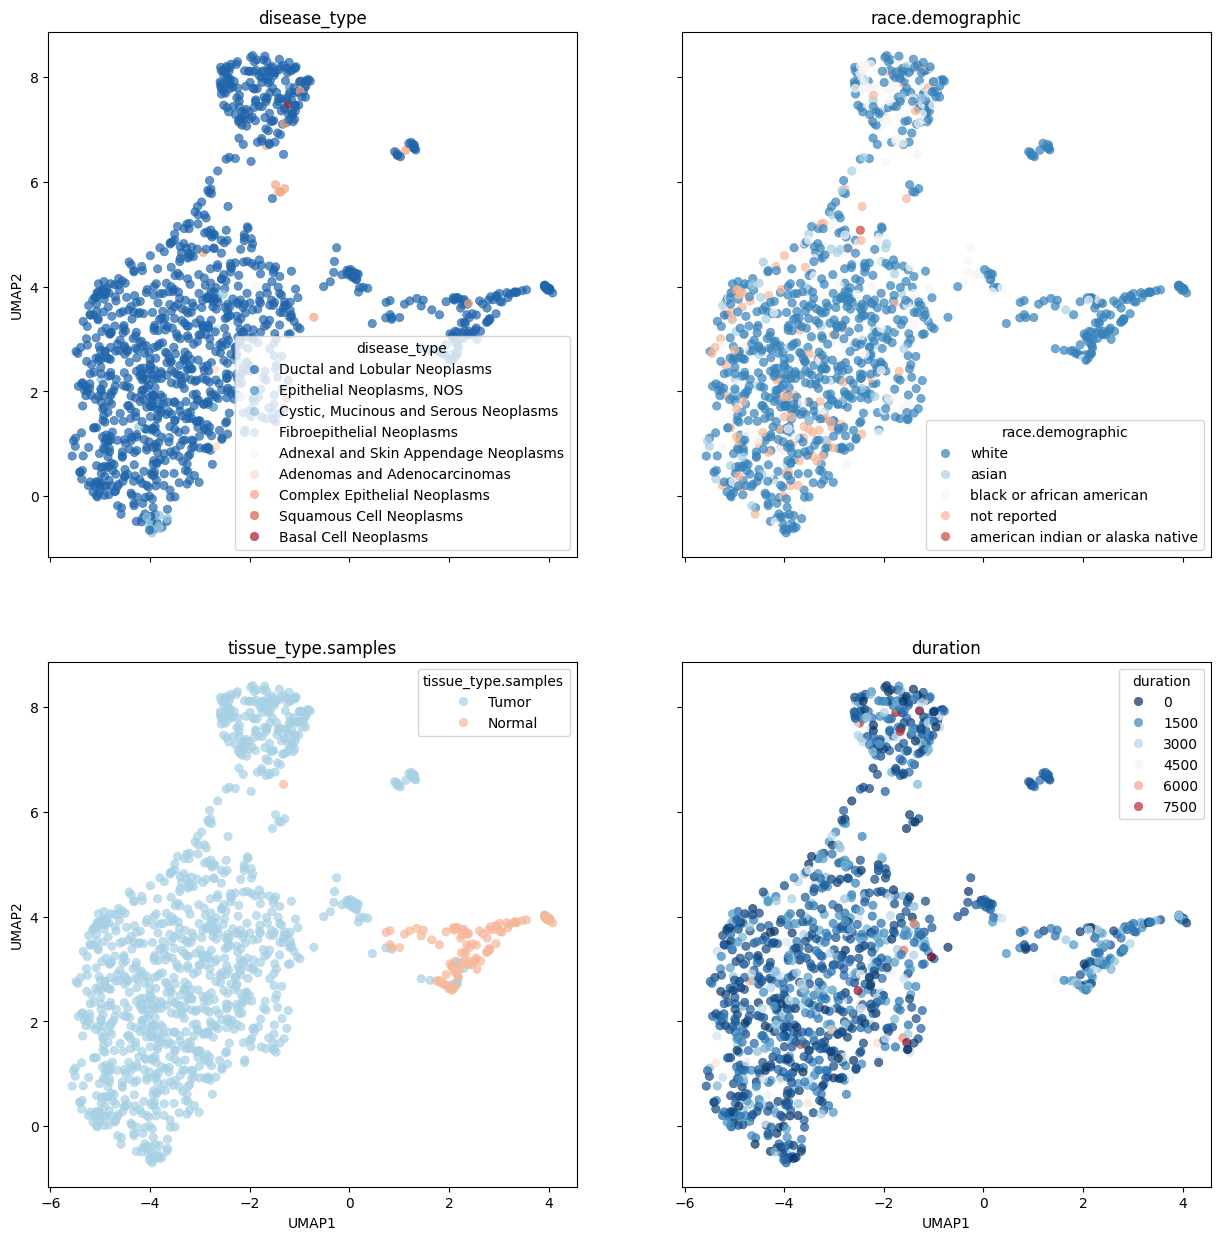

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_scatter(df, x_col='UMAP1', y_col='UMAP2', color_col='category', axes=None):
    """
    Plots a scatterplot of the given DataFrame with x, y, and color based on a categorical column.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        x_col (str): The column name for the x-axis. Default is 'UMAP1'.
        y_col (str): The column name for the y-axis. Default is 'UMAP2'.
        color_col (str): The column name for coloring the points. Default is 'category'.

    Returns:
        None
    """
    if axes is None:
        _, axes = plt.subplots(figsize=(10, 10))
    sns.scatterplot(
        data=df, 
        x=x_col, 
        y=y_col, 
        hue=color_col, 
        palette='RdBu_r',
        edgecolor=None,
        alpha=0.7,
        ax = axes
        )
    axes.set_title(color_col)
    axes.set_xlabel(x_col)
    axes.set_ylabel(y_col)
    axes.legend(title=color_col)
    
color_cols = [
    "disease_type", 
    "race.demographic",
    "tissue_type.samples",
    "duration",
]
_, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=True, sharey=True)
for i in range(2):
    for j in range(2):
        col_idx = i * 2 + j
        plot_scatter(reduced_df, color_col=color_cols[col_idx], axes=axes[i, j])
        

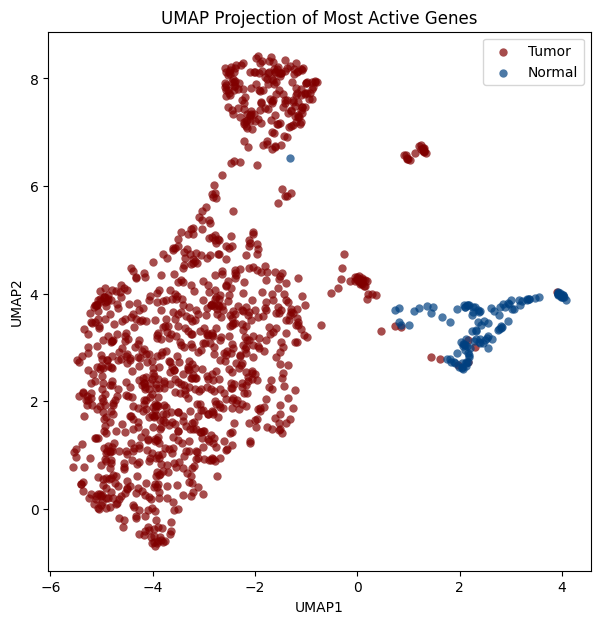

In [32]:
plt.figure(figsize=(7, 7))
for idx, tissue_type in enumerate(reduced_df['tissue_type.samples'].unique()):
    plt.scatter(
        reduced_df[reduced_df['tissue_type.samples']==tissue_type]['UMAP1'], 
        reduced_df[reduced_df['tissue_type.samples']==tissue_type]['UMAP2'], 
        color = [[0.5, 0, 0], [0, 0.25, 0.5]][idx], 
        alpha=0.7,
        linewidth=0, 
        label=tissue_type
        )
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Projection of Most Active Genes')
plt.legend();

The UMAP plot reveals a remarkable separation between the 'Tumor' and 'Normal' samples. The normal samples form a tight, distinct cluster, while the tumor samples show much more heterogeneity and occupy a vast, separate space. This confirms that the primary source of variation within the top 1% most active genes is indeed the cancer signal itself.

In [23]:
df_clinical['disease_type'].value_counts()

disease_type
Ductal and Lobular Neoplasms             1208
Complex Epithelial Neoplasms               17
Cystic, Mucinous and Serous Neoplasms      16
Epithelial Neoplasms, NOS                   5
Adenomas and Adenocarcinomas                3
Fibroepithelial Neoplasms                   2
Squamous Cell Neoplasms                     2
Basal Cell Neoplasms                        1
Adnexal and Skin Appendage Neoplasms        1
Name: count, dtype: int64

In [ ]:
plt.figure(figsize=(7, 7))
for idx, tissue_type in enumerate(reduced_df['tissue_type.samples'].unique()):
    plt.scatter(
        reduced_df[reduced_df['tissue_type.samples']==tissue_type]['UMAP1'], 
        reduced_df[reduced_df['tissue_type.samples']==tissue_type]['UMAP2'], 
        color = [[0.5, 0, 0], [0, 0.25, 0.5]][idx], 
        alpha=0.7,
        linewidth=0, 
        label=tissue_type
        )
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Projection of Most Active Genes')
plt.legend();

**Observations**: 
*

---
### 8. Summary

...